In [22]:
import numpy as np 
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

Simple vanilla gradient descent. This implementation isn't efficient and it's better to use quasi-newton methods such as BFGS for optimization problem.

In [23]:
def gradient(func, x, h=0.001):
        I = np.eye(len(x))
        return np.array([(func(x + h*_I) - func(x - h*_I))/(2.0*h) for _I in I])

class GradientDescent:
    
    def __init__(self, func, x, rate, grad=gradient, theta=0.5, delta=0.5, eps=0.001):
        self.func = func
        self.x = x
        self.rate = rate
        self.grad = grad
        self.theta = theta
        self.delta = delta
        self.eps = eps
        
    
    def minimize(self):
        iteration = 0
        while True:
            grad = self.grad(self.func, self.x)
            next_x = self.x - self.rate*grad
            
            # calculating efficient rate
            rate = self.rate
            while self.func(next_x) - self.func(self.x) > -self.theta*rate*np.linalg.norm(grad)**2: 
                rate = rate*self.delta
                next_x = self.x - rate*grad
                
            # boolean flags to check did algorithm converge
            args_error = np.linalg.norm(np.array(self.x) - np.array(next_x)) < self.eps
            func_error = abs(self.func(next_x) - self.func(self.x)) < self.eps
            grad_error = np.linalg.norm(gradient(self.func, next_x)) < self.eps
            
            self.x = next_x
            iteration += 1
            
            if args_error and func_error and grad_error:
                return {'x': self.x, 'f(x)': self.func(self.x), 'iter': iteration}
            elif iteration == 10000:
                print('max iter reached, try to change parameters')
                return None
            
        

Tested on Rosenbrock function, which is a standart benchmark for optimization methods.


In [24]:
rosenbrock = lambda x: (1 - x[0])**2 + 100*(x[1] - x[0]**2)**2
init_x = [2., 2.]
rate = 0.1

optim = GradientDescent(rosenbrock, init_x, rate)
optim.minimize()

{'f(x)': 8.0004042310365339e-07,
 'iter': 5108,
 'x': array([ 1.00089352,  1.00179192])}

But for machine learning purposes is better to use stochastic gradient descent. 
There is a simple implementation of Adam SGD algorithm for linear and logistic regression. We will use PCA to reduce iris data dimension from 4 to 2 for better visualization.


In [25]:
class PCA:
    
    def __init__(self):
        self.reduction_mat = None
    
    def fit(self, data, num_components):
        data = np.array(data)
        data = data - data.mean(axis=0)
        
        eig_vecs = np.linalg.svd(np.cov(data, rowvar=False))[0]
        self.reduction_mat = eig_vecs[:, :num_components]
        
    def transform(self, x):
        transformed_x = [np.matmul(self.reduction_mat.T, _x) for _x in x]
        return np.array(transformed_x)


In [26]:
class AdamRegressor:
    
    def __init__(self, regr_type, l2=False, l2_rate=0.01, rate=0.1, beta1=0.9, beta2=0.999, zero_correction = 1e-8):
        self.regr_type = regr_type
        self.l2 = l2
        self.l2_rate = l2_rate
        self.rate = rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.zero_correction = zero_correction
        
        self.theta = None
        self.timestep = 0
        self.moment1 = 0
        self.moment2 = 0
        
    def gradient(self, x, y):
        x = np.append(x, [1])
        
        if self.regr_type == 'linear':
            tmp = (x*self.theta).sum() - y    
        elif self.regr_type == 'logistic':
            tmp = 1./(1. + np.exp(-(x*self.theta).sum())) - y
        
        grad = x*tmp
        
        if self.l2:
            grad = grad + self.l2_rate*self.theta
        
        return np.array(grad)
    
    def train_step(self, batch_x, batch_y):
        self.timestep += 1
        grads = []
        for x, y in zip(batch_x, batch_y):
            grads.append(self.gradient(x, y))
        grad = np.sum(grads, axis=0)/len(grads)

        self.moment1 = self.beta1*self.moment1 + (1 - self.beta1)*grad
        self.moment2 = self.beta2*self.moment2 + (1 - self.beta2)*grad**2
        timestep_rate = self.rate*np.sqrt(1 - self.beta2**self.timestep)/(1 - self.beta1**self.timestep)

        self.theta = self.theta - timestep_rate*self.moment1/(np.sqrt(self.moment2) + self.zero_correction)
        
    def fit(self, x, y, batch_size, epoch_num):
        if hasattr(x[0], "__len__"):
            feats_size = len(x[0])
        else:
            feats_size = 1
        num_batches = len(x)//batch_size
        x = np.reshape(x[: num_batches*batch_size], [num_batches, batch_size, feats_size])
        y = np.reshape(y[: num_batches*batch_size], [num_batches, batch_size])
        
        self.theta = np.random.random(feats_size + 1)
        for epoch in range(epoch_num):
            for batch_x, batch_y in zip(x,y):
                self.train_step(batch_x, batch_y)
                
    def predict(self, x):
        x = np.array([np.append(_x, [1]) for _x in x])
        if self.regr_type == 'linear':
            prediction = np.array([(_x*self.theta).sum() for _x in x])
        elif self.regr_type == 'logistic':
            probs = np.array([1./(1. + np.exp(-(_x*self.theta).sum())) for _x in x])
            probs = np.array([[prob, 1 - prob] for prob in probs])
            prediction = [probs, np.array([prob.argmax() for prob in probs])]
        return prediction
    
        

In [27]:
# loading data
data = datasets.load_iris()
data, labels, feat_names = data.data, data.target, data.feature_names

In [28]:
# have a look on covariation matrix to find correlated features
print(feat_names)
np.cov(data, rowvar=False)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


array([[ 0.68569351, -0.03926846,  1.27368233,  0.5169038 ],
       [-0.03926846,  0.18800403, -0.32171275, -0.11798121],
       [ 1.27368233, -0.32171275,  3.11317942,  1.29638747],
       [ 0.5169038 , -0.11798121,  1.29638747,  0.58241432]])

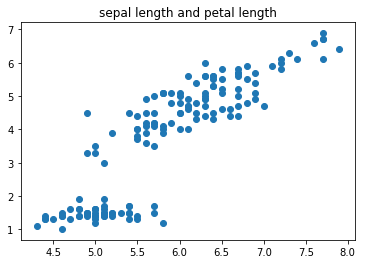

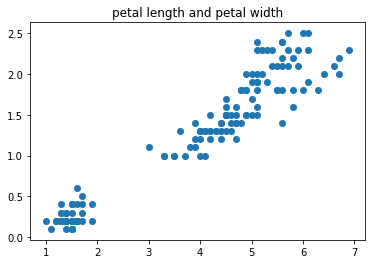

In [29]:
# we see that 'sepal length' highly correlated with 'petal length'
# and 'petal length' with 'petal width'
plt.figure(1)
plt.title('sepal length and petal length')
plt.scatter(data[:, 0], data[:, 2])

plt.figure(2)
plt.title('petal length and petal width')
plt.scatter(data[:, 2], data[:, 3])

In [30]:
# second plot looks better for testing linear regression, so we will try
# to predict petal width based on petal length
x = data[:, 2]
y = data[:, 3]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.1)

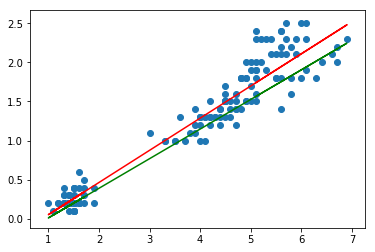

In [31]:
lin = AdamRegressor('linear')
lin.fit(train_x, train_y, batch_size=5, epoch_num=20)

sklearn_lin = LinearRegression()
sklearn_lin.fit(train_x.reshape(-1, 1), train_y)

parameters = lin.theta
sk_parameters = sklearn_lin.coef_, sklearn_lin.intercept_

plt.plot(x, parameters[0]*x + parameters[1], 'g')
plt.plot(x, sk_parameters[0]*x + sk_parameters[1], 'r')
plt.scatter(x, y)

In [32]:
# taking data only for 2 classes
data = data[:100,]
labels = labels[:100]

# dimension reduction
pc = PCA()
pc.fit(data, 2)
data = pc.transform(data)

# splitting data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

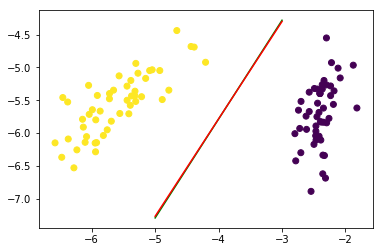

In [33]:
log = AdamRegressor('logistic', l2=True)
log.fit(train_data, train_labels, 5, 20)

sklearn_log = LogisticRegression()
sklearn_log.fit(train_data, train_labels)

parameters = log.theta
sk_parameters = sklearn_log.coef_.reshape(2)[0], sklearn_log.coef_.reshape(2)[1], sklearn_log.intercept_
x_points = np.linspace(-5, -3, 1000)

plt.plot(x_points, -parameters[2]/parameters[1]-x_points*parameters[0]/parameters[1], 'g')
plt.plot(x_points, -sk_parameters[2]/sk_parameters[1]-x_points*sk_parameters[0]/sk_parameters[1], 'r')
plt.scatter(data[:, 0], data[:, 1], c=labels)